# Load in Precupitation Data

/var/folders/dm/_7xx464s467cm2g79s2z8cvw0000gq/T/ipykernel_28365/984565802.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 1])  # Leave space for colorbar


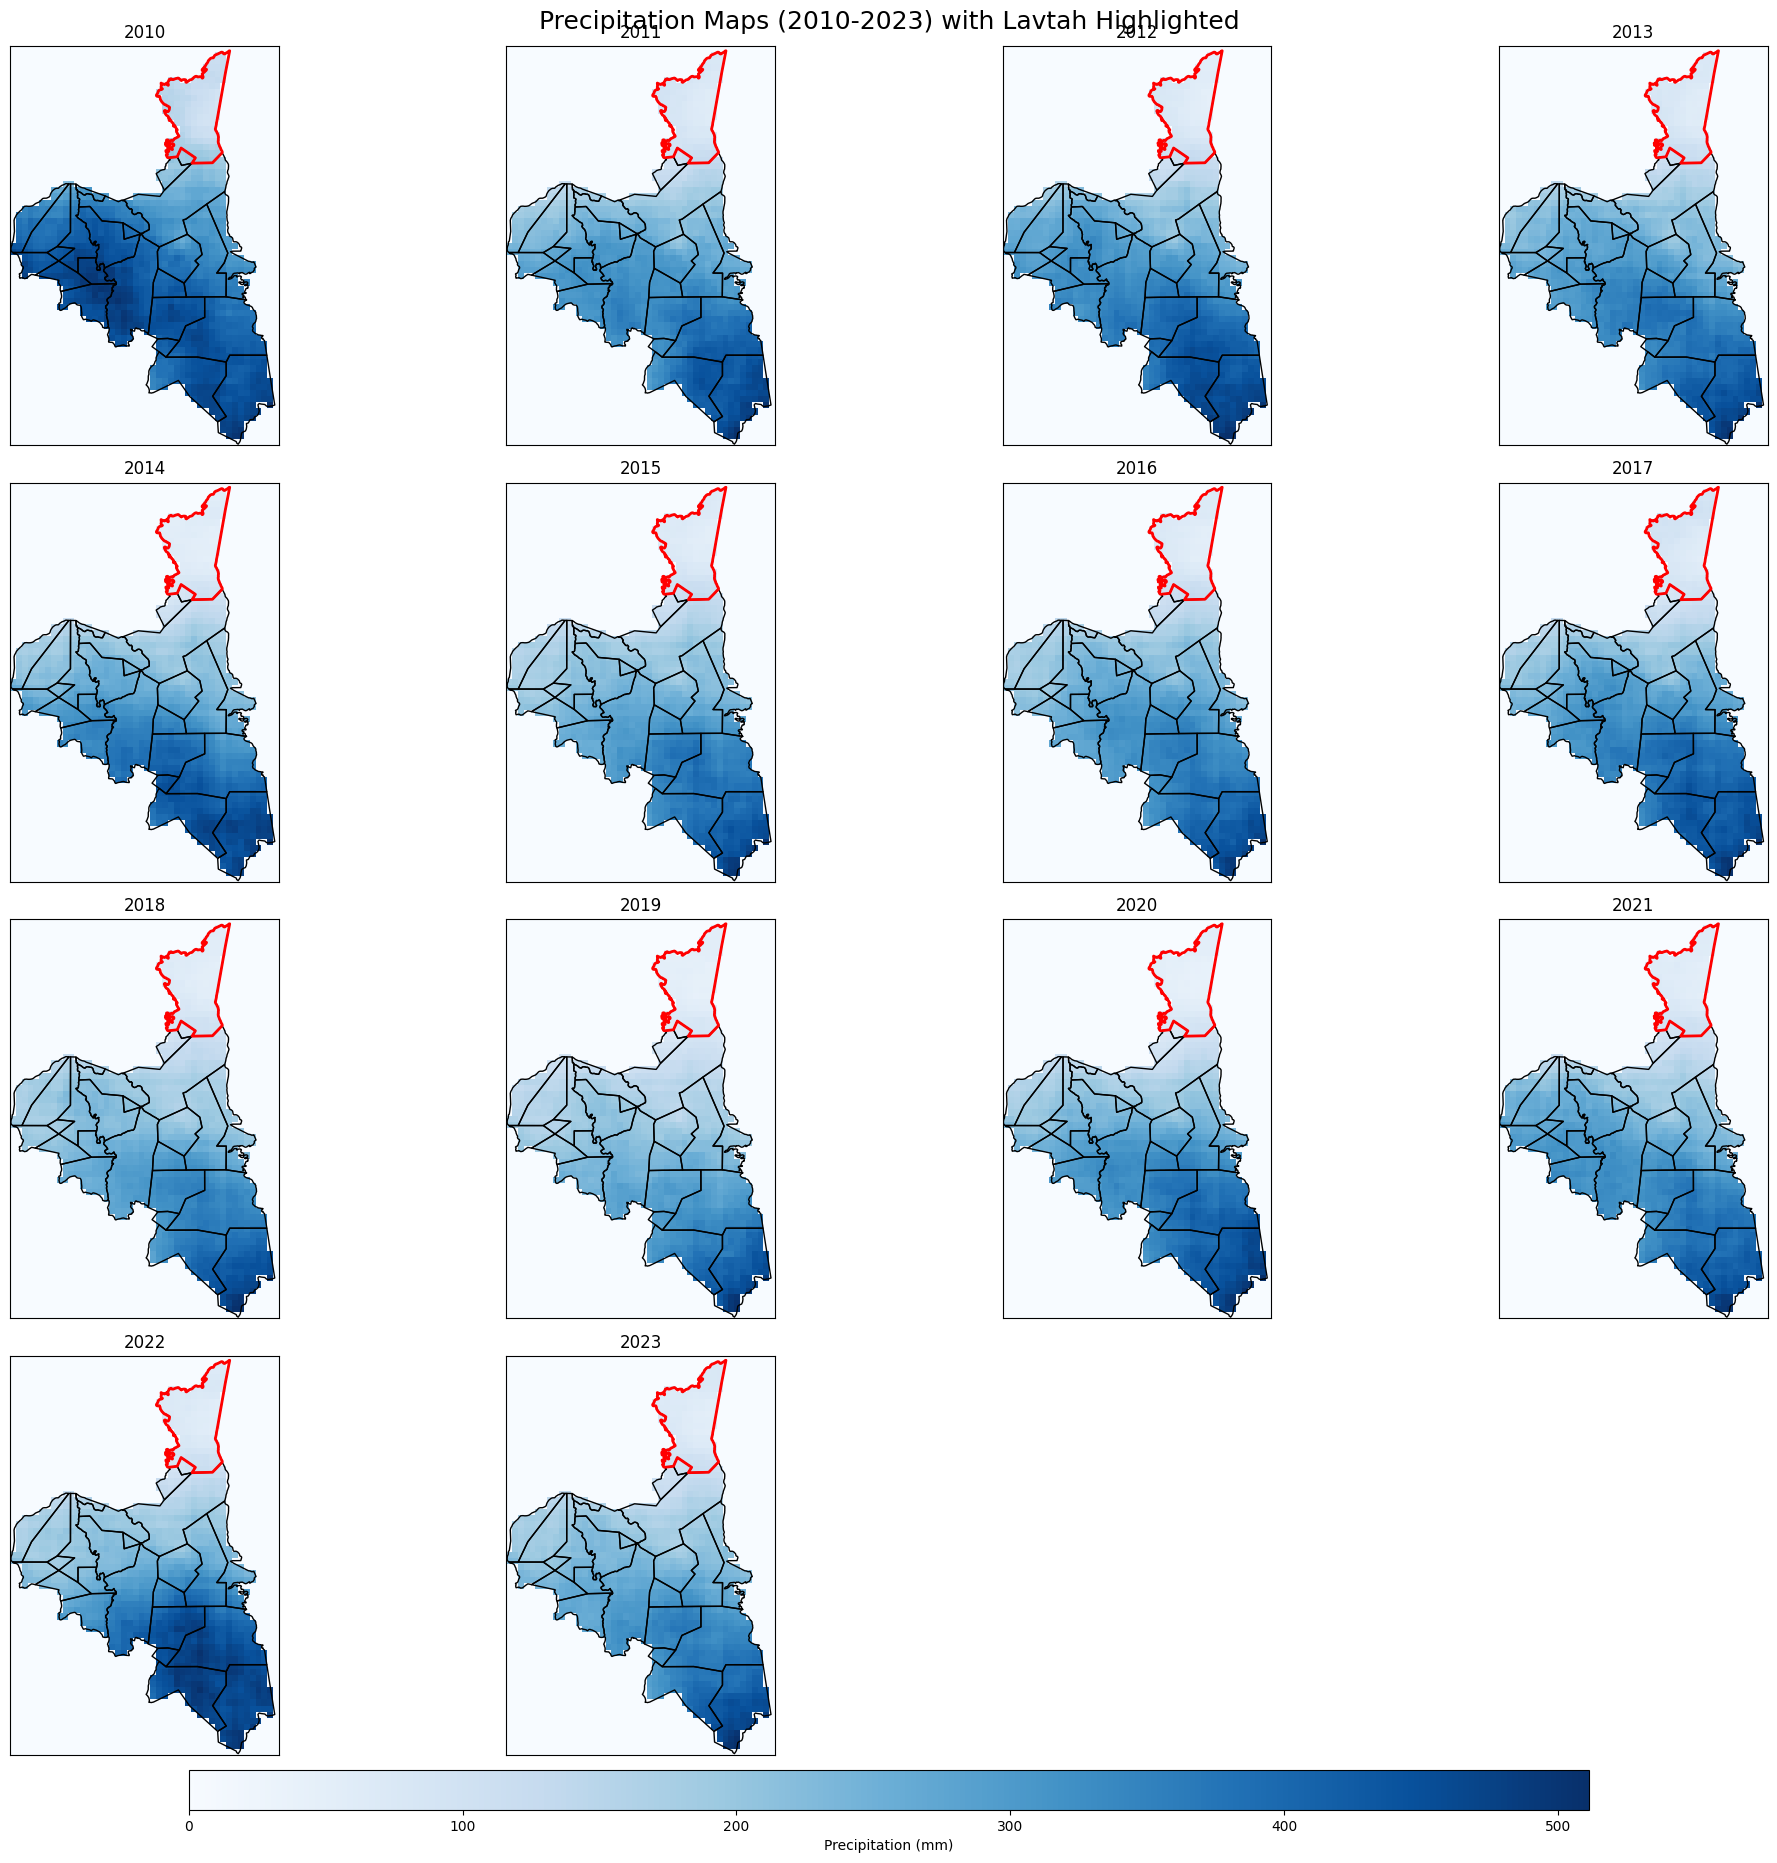

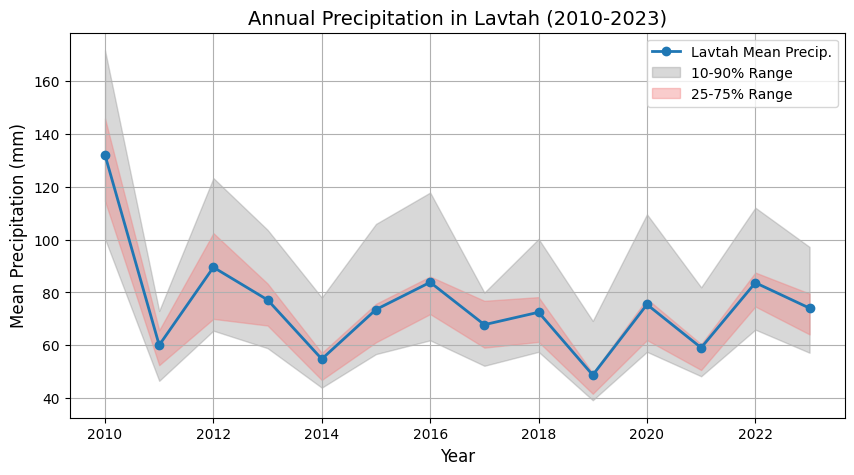

In [49]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping

# Define dataset paths
data_dir = "/Users/niklasviebig/Desktop/STARTxHack/Datasets_Hackathon/Climate_Precipitation_Data"
shp_file = "/Users/niklasviebig/Desktop/STARTxHack/Datasets_Hackathon/Admin_layers/Assaba_Districts_layer.shp"

def extract_precipitation_for_municipality(tif_file, shp_file, year, municipality_name):
    """Extracts precipitation data for a specific municipality."""
    assaba_map = gpd.read_file(shp_file)
    
    # Select the specified municipality
    municipality = assaba_map[assaba_map["ADM3_EN"] == municipality_name]
    if municipality.empty:
        print(f"❌ Municipality '{municipality_name}' not found.")
        return None

    with rasterio.open(tif_file) as dataset:
        clipped_data, _ = mask(dataset, municipality.geometry.map(mapping), crop=True)

    clipped_data = clipped_data.astype(float)
    clipped_data[clipped_data == dataset.nodata] = np.nan

    mean_precip = np.nanmean(clipped_data)
    percentile_10 = np.nanpercentile(clipped_data, 10)
    percentile_25 = np.nanpercentile(clipped_data, 25)
    percentile_75 = np.nanpercentile(clipped_data, 75)
    percentile_90 = np.nanpercentile(clipped_data, 90)

    return {
        "Year": year,
        "Mean": mean_precip,
        "P10": percentile_10,
        "P25": percentile_25,
        "P75": percentile_75,
        "P90": percentile_90
    }

def plot_municipality_with_total(tif_file, shp_file, year, municipality_name, ax):
    """Plots total precipitation with a highlighted municipality in a shared subplot."""
    assaba_map = gpd.read_file(shp_file)
    
    # Select the specified municipality
    municipality = assaba_map[assaba_map["ADM3_EN"] == municipality_name]
    if municipality.empty:
        print(f"❌ Municipality '{municipality_name}' not found.")
        return None

    with rasterio.open(tif_file) as dataset:
        raster_crs = dataset.crs
        assaba_map = assaba_map.to_crs(raster_crs)
        clipped_data, clipped_transform = mask(dataset, assaba_map.geometry.map(mapping), crop=True)
        municipality_data, _ = mask(dataset, municipality.geometry.map(mapping), crop=True)

    clipped_data = clipped_data.astype(float)
    clipped_data[clipped_data == dataset.nodata] = 0

    municipality_data = municipality_data.astype(float)
    municipality_data[municipality_data == dataset.nodata] = 0

    height, width = clipped_data.shape[1:]
    row_indices, col_indices = np.meshgrid(np.arange(height), np.arange(width), indexing="ij")
    lon, lat = rasterio.transform.xy(clipped_transform, row_indices, col_indices)
    lon = np.array(lon).reshape(clipped_data.shape[1:])
    lat = np.array(lat).reshape(clipped_data.shape[1:])

    mean_precip = np.nanmean(municipality_data)

    im = ax.pcolormesh(lon, lat, clipped_data[0], cmap="Blues", shading="auto")
    assaba_map.boundary.plot(ax=ax, edgecolor="black", linewidth=1)
    municipality.boundary.plot(ax=ax, edgecolor="red", linewidth=2)

    ax.set_title(f"{year}")
    ax.set_xticks([])
    ax.set_yticks([])

    return mean_precip, im

# Get all .tif files
tif_files = sorted([f for f in os.listdir(data_dir) if f.endswith(".tif")])

municipality_name = "Lavtah"  

# Set up the figure with multiple subplots
num_years = len(tif_files)
cols = 4
rows = (num_years // cols) + (num_years % cols > 0)
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
axes = axes.flatten()

for i, tif in enumerate(tif_files):
    year = int(tif[:4])  
    file_path = os.path.join(data_dir, tif)

    mean_precip, im = plot_municipality_with_total(file_path, shp_file, year, municipality_name, axes[i])
    
# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and place the colorbar at the bottom
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation="horizontal", label="Precipitation (mm)")

fig.suptitle(f"Precipitation Maps (2010-2023) with {municipality_name} Highlighted", fontsize=18)
plt.tight_layout(rect=[0, 0.1, 1, 1])  # Leave space for colorbar
plt.show()

# Convert to DataFrame
municipality_data = [
    extract_precipitation_for_municipality(os.path.join(data_dir, tif), shp_file, int(tif[:4]), municipality_name)
    for tif in tif_files if extract_precipitation_for_municipality(os.path.join(data_dir, tif), shp_file, int(tif[:4]), municipality_name) is not None
]
municipality_df = pd.DataFrame(municipality_data)

# Plot mean precipitation trends for the municipality
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot total precipitation trend
ax1.plot(municipality_df["Year"], municipality_df["Mean"], marker="o", linestyle="-", linewidth=2, label=f"{municipality_name} Mean Precip.")
ax1.fill_between(municipality_df["Year"], municipality_df["P10"], municipality_df["P90"], color="gray", alpha=0.3, label="10-90% Range")
ax1.fill_between(municipality_df["Year"], municipality_df["P25"], municipality_df["P75"], color="lightcoral", alpha=0.4, label="25-75% Range")

ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Mean Precipitation (mm)", fontsize=12)
ax1.tick_params(axis='y')

ax1.set_title(f"Annual Precipitation in {municipality_name} (2010-2023)", fontsize=14)
ax1.grid(True)
ax1.legend()

plt.show()

Dataset Metadata:
Years Available: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


/var/folders/dm/_7xx464s467cm2g79s2z8cvw0000gq/T/ipykernel_28365/3428227454.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit colorbar


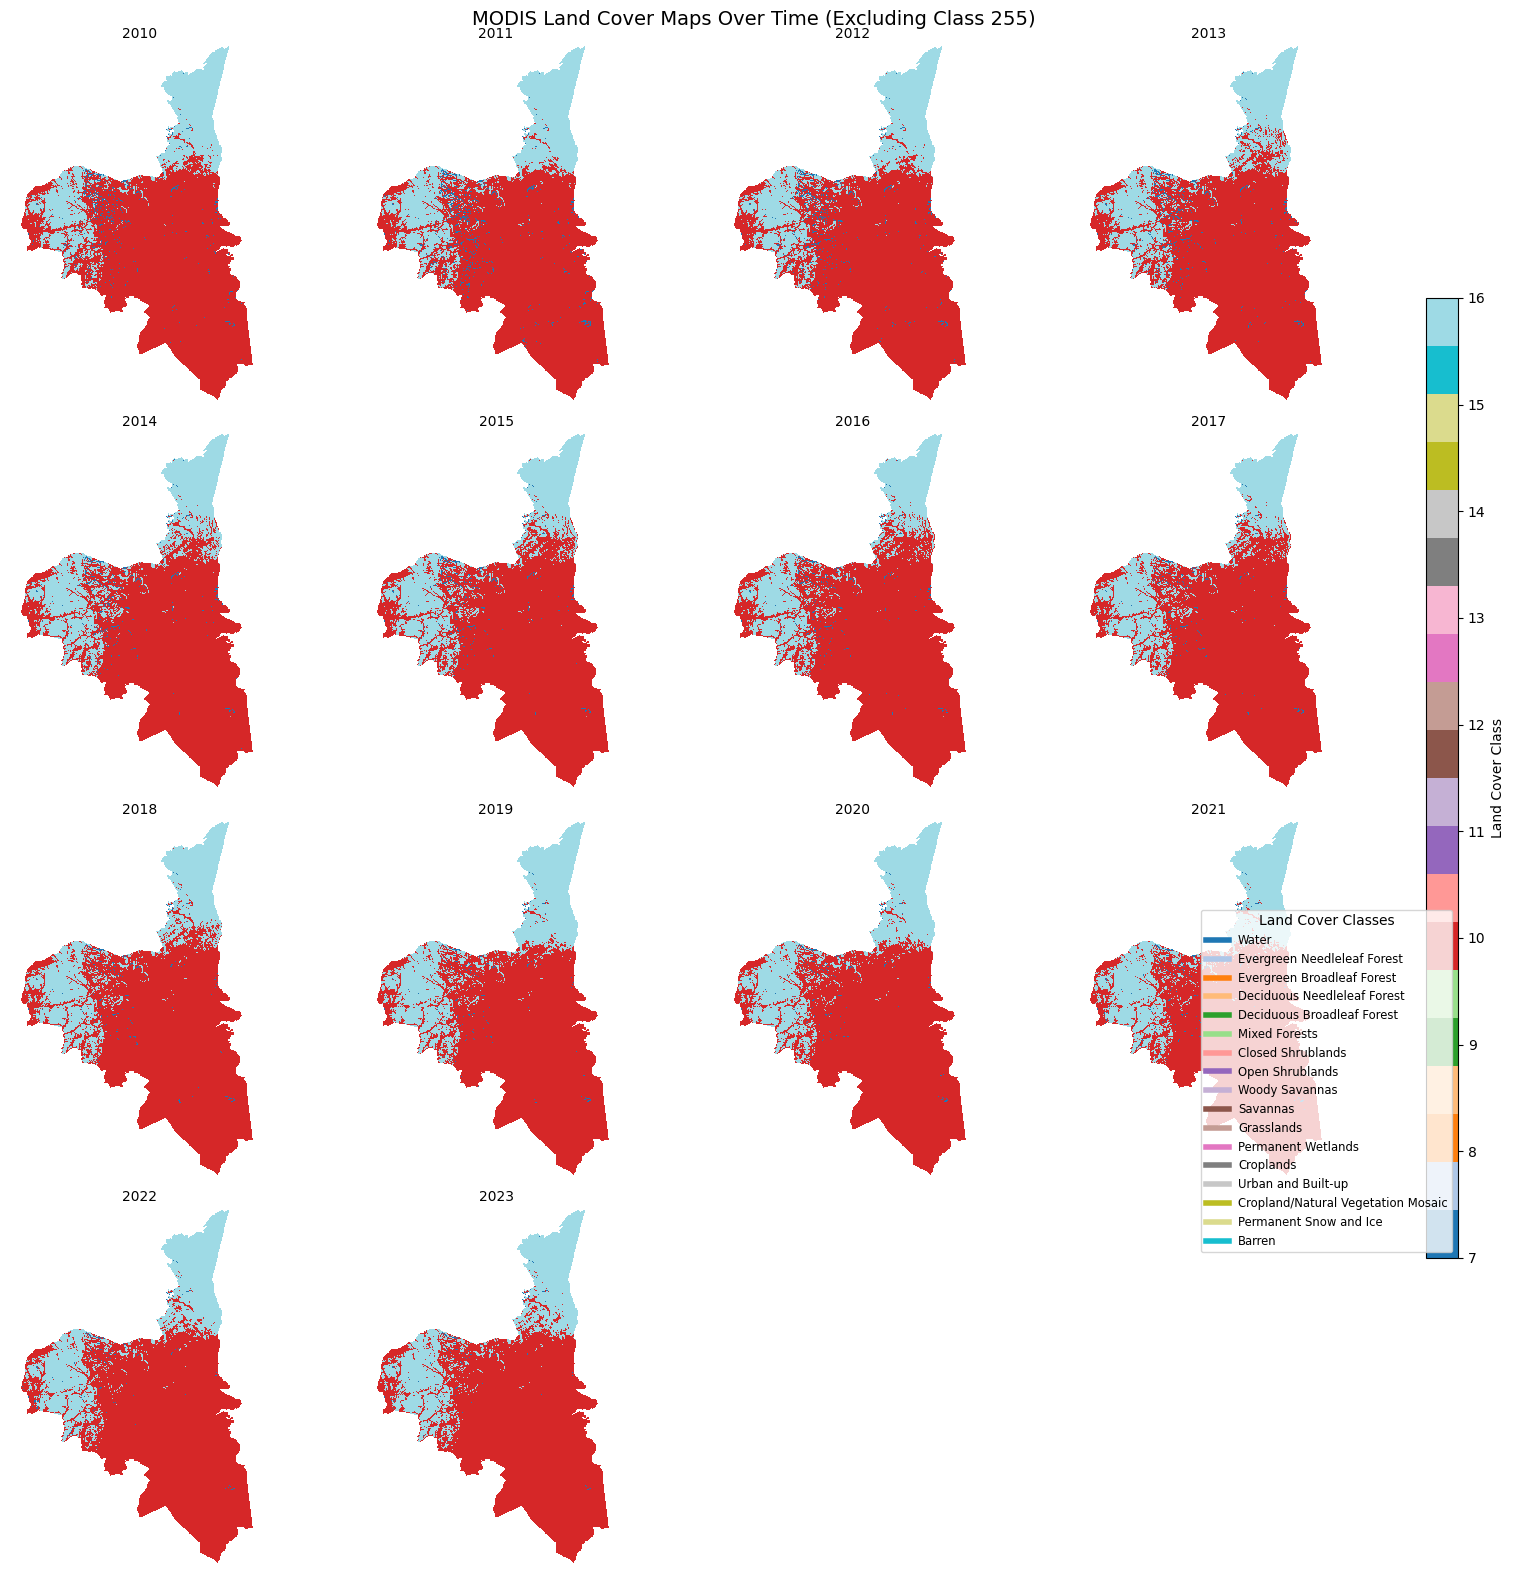

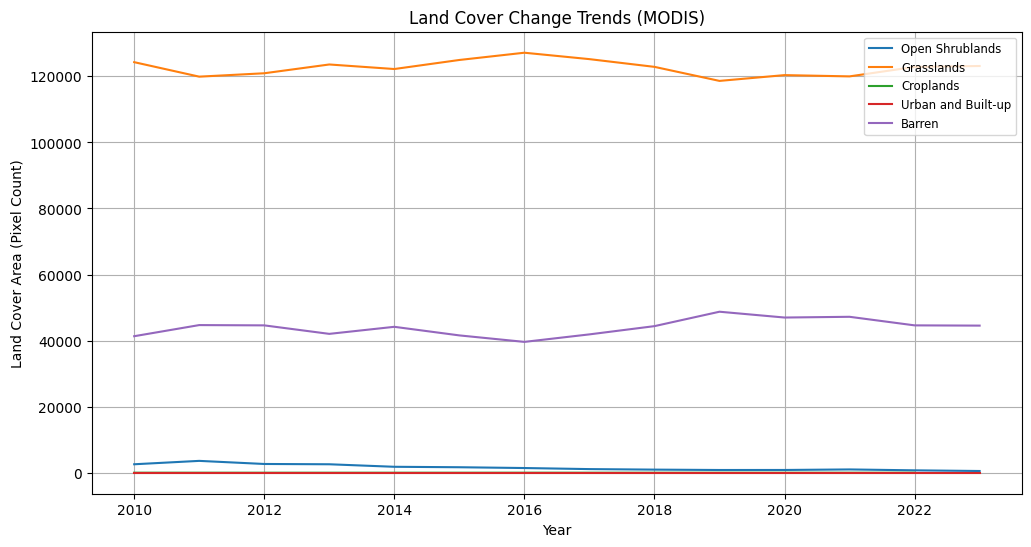

/var/folders/dm/_7xx464s467cm2g79s2z8cvw0000gq/T/ipykernel_28365/3428227454.py:132: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gif_frames.append(imageio.imread(temp_path))


✅ Land Cover Change GIF saved as 'land_cover_change.gif'


,Open Shrublands,Grasslands,Croplands,Urban and Built-up,Barren
2010,1.522484,73.897225,0.004161,0.004756,24.571374
2011,2.133023,71.288612,NaN,0.004756,26.573609
2012,1.574204,71.898557,0.000594,0.004756,26.521889
2013,1.521889,73.480489,NaN,0.004756,24.992866
2014,1.068889,72.662474,0.001189,0.004756,26.262692
2015,0.986850,74.290776,0.000594,0.004756,24.717024
2016,0.845362,75.596271,0.004161,0.004756,23.549450
2017,0.652153,74.442370,NaN,0.004756,24.900721
2018,0.558224,73.051863,0.000594,0.004756,26.384562
2019,0.491047,70.524695,0.000594,0.004756,28.978908


In [50]:
	
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import math
import seaborn as sns
import imageio
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

# 🔹 Set the folder containing MODIS Land Cover TIFF files
data_folder = "/Users/niklasviebig/Desktop/STARTxHack/Datasets_Hackathon/Modis_Land_Cover_Data"  # Change to your actual folder path

# ✅ Define Correct MODIS Land Cover Classes (Excluding 255)
land_cover_classes = {
    0: "Water",
    1: "Evergreen Needleleaf Forest",
    2: "Evergreen Broadleaf Forest",
    3: "Deciduous Needleleaf Forest",
    4: "Deciduous Broadleaf Forest",
    5: "Mixed Forests",
    6: "Closed Shrublands",
    7: "Open Shrublands",
    8: "Woody Savannas",
    9: "Savannas",
    10: "Grasslands",
    11: "Permanent Wetlands",
    12: "Croplands",
    13: "Urban and Built-up",
    14: "Cropland/Natural Vegetation Mosaic",
    15: "Permanent Snow and Ice",
    16: "Barren"  # Use for unknowns
}

# ✅ Remove Invalid Classes (255)
valid_classes = set(land_cover_classes.keys())  # Allow only defined land cover categories

# 🔹 Store Data
land_cover_data = {}  # Stores raster arrays per year
land_cover_stats = {}  # Stores land cover distribution per year
years = []  # Store available years

# 🔹 Load all TIFF files in the folder
for filename in sorted(os.listdir(data_folder)):
    if filename.endswith(".tif"):  # Process only .tif files
        year = int(filename[:4])  # Extract the year from filename (e.g., "2010LCT.tif")
        years.append(year)
        file_path = os.path.join(data_folder, filename)

        with rasterio.open(file_path) as src:
            raw_data = src.read(1)  # Read the first band (land cover classes)

            # ✅ Remove invalid class 255 (Unclassified)
            cleaned_data = np.where((raw_data == 255) | (raw_data ==-128)  , np.nan, raw_data)
            land_cover_data[year] = cleaned_data

            # ✅ Compute statistics for land cover distribution (excluding invalid pixels)
            unique, counts = np.unique(cleaned_data[~np.isnan(cleaned_data)], return_counts=True)
            land_cover_stats[year] = {int(k): v for k, v in zip(unique, counts) if int(k) in valid_classes}

# 🔹 Display Dataset Metadata
print("Dataset Metadata:")
print(f"Years Available: {years}")

# ✅ Grid Layout for Visualization
num_years = len(years)
cols = 4  # Number of columns in the grid (adjust as needed)
rows = math.ceil(num_years / cols)  # Automatically calculate required rows

# 🔹 Create a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))  # Adjust figure size
axes = axes.flatten()

# 🔹 Loop through each year and plot land cover data
for i, year in enumerate(years):
    ax = axes[i]
    ax.set_title(f"{year}", fontsize=10)
    im = ax.imshow(land_cover_data[year], cmap="tab20", interpolation="nearest")
    ax.axis("off")  # Hide axis for cleaner visualization

# 🔹 Remove any extra empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 🔹 Add a colorbar (common for all subplots)
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Position the colorbar
fig.colorbar(im, cax=cbar_ax, label="Land Cover Class")

# 🔹 Add Class Labels to Legend
legend_patches = [plt.Line2D([0], [0], color=plt.cm.tab20(i / len(valid_classes)), lw=4, label=label)
                  for i, (lc, label) in enumerate(land_cover_classes.items()) if lc in valid_classes]
plt.legend(handles=legend_patches, loc='lower right', fontsize="small", title="Land Cover Classes")

# 🔹 Show final grid layout
plt.suptitle("MODIS Land Cover Maps Over Time (Excluding Class 255)", fontsize=14)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit colorbar
plt.show()

# 🔹 Analyze Land Cover Change Over Time
land_cover_trends = defaultdict(list)

for year in years:
    for lc_class, count in land_cover_stats[year].items():
        land_cover_trends[lc_class].append((year, count))

# 🔹 Plot Trends for Key Land Cover Classes
plt.figure(figsize=(12, 6))
for lc_class, trend in land_cover_trends.items():
    years_list, values = zip(*trend)
    plt.plot(years_list, values, label=land_cover_classes.get(lc_class, f"Class {lc_class}"))

plt.xlabel("Year")
plt.ylabel("Land Cover Area (Pixel Count)")
plt.title("Land Cover Change Trends (MODIS)")
plt.legend(loc="upper right", fontsize="small")
plt.grid()
plt.show()

# 🔹 Create Land Cover Animation Over Time
gif_frames = []
for year in years:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(f"Land Cover Change ({year})")
    im = ax.imshow(land_cover_data[year], cmap="tab20", interpolation="nearest")
    plt.colorbar(im, ax=ax)

    # Save each frame
    temp_path = f"frame_{year}.png"
    plt.savefig(temp_path)
    plt.close()
    gif_frames.append(imageio.imread(temp_path))
    os.remove(temp_path)  # Remove temp files after saving

# 🔹 Save GIF Animation
imageio.mimsave("land_cover_change.gif", gif_frames, duration=1)
print("✅ Land Cover Change GIF saved as 'land_cover_change.gif'")

# 🔹 Generate Summary Statistics
summary_stats = {}

for year, stats in land_cover_stats.items():
    total_pixels = sum(stats.values())
    summary_stats[year] = {land_cover_classes.get(k, f"Class {k}"): (v / total_pixels) * 100 for k, v in stats.items()}

df_summary = pd.DataFrame(summary_stats).T 
df_summary

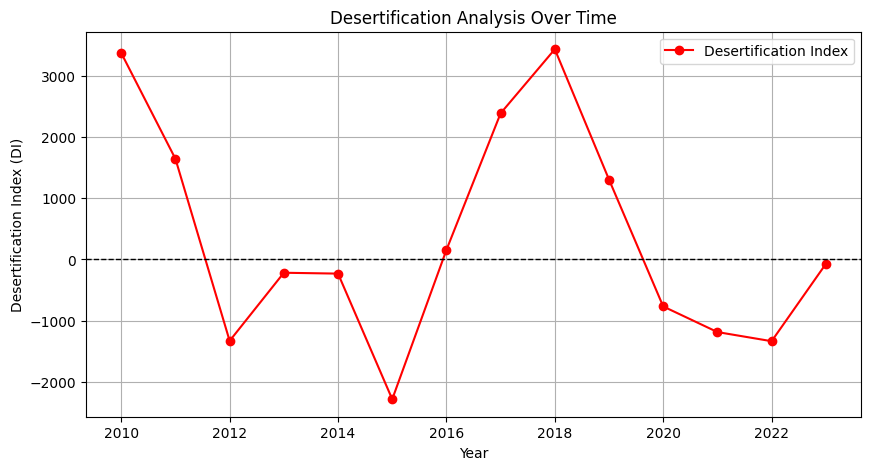

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 🔹 Extract land cover classes of interest (ensure valid keys exist)
barren_trend = land_cover_trends.get(16, [])  # Barren Land
vegetation_trend = land_cover_trends.get(7, []) + land_cover_trends.get(10, [])  # Shrubs + Grasslands

# ✅ Convert lists of tuples [(year, count), (year, count)] into separate arrays
years_barren, barren_values = zip(*barren_trend) if barren_trend else ([], [])
years_vegetation, vegetation_values = zip(*vegetation_trend) if vegetation_trend else ([], [])

# ✅ Ensure both lists are the same length (only process overlapping years)
common_years = list(set(years_barren) & set(years_vegetation))
common_years.sort()

# 🔹 Get only values for matching years
barren_values = [barren_values[years_barren.index(y)] for y in common_years]
vegetation_values = [vegetation_values[years_vegetation.index(y)] for y in common_years]

# 🔹 Compute changes over time (first-order difference)
delta_barren = np.gradient(barren_values)  # Change in barren land
delta_vegetation = np.gradient(vegetation_values)  # Change in vegetation

# 🔹 Load Climate Data (Dummy values - replace with actual GEE queries)
delta_temperature = np.linspace(0.1, 0.5, len(common_years))  # Fake temperature trend
delta_rainfall = np.linspace(-5, 5, len(common_years))  # Fake rainfall trend

# ✅ Compute the Desertification Index (DI)
DI = delta_barren

# 🔹 Plot the Desertification Index
plt.figure(figsize=(10, 5))
plt.plot(common_years, DI, marker="o", linestyle="-", color="red", label="Desertification Index")
plt.axhline(0, color="black", linestyle="--", linewidth=1)  # Reference line
plt.xlabel("Year")
plt.ylabel("Desertification Index (DI)")
plt.title("Desertification Analysis Over Time")
plt.legend()
plt.grid()
plt.show()


/var/folders/dm/_7xx464s467cm2g79s2z8cvw0000gq/T/ipykernel_28365/3519167152.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


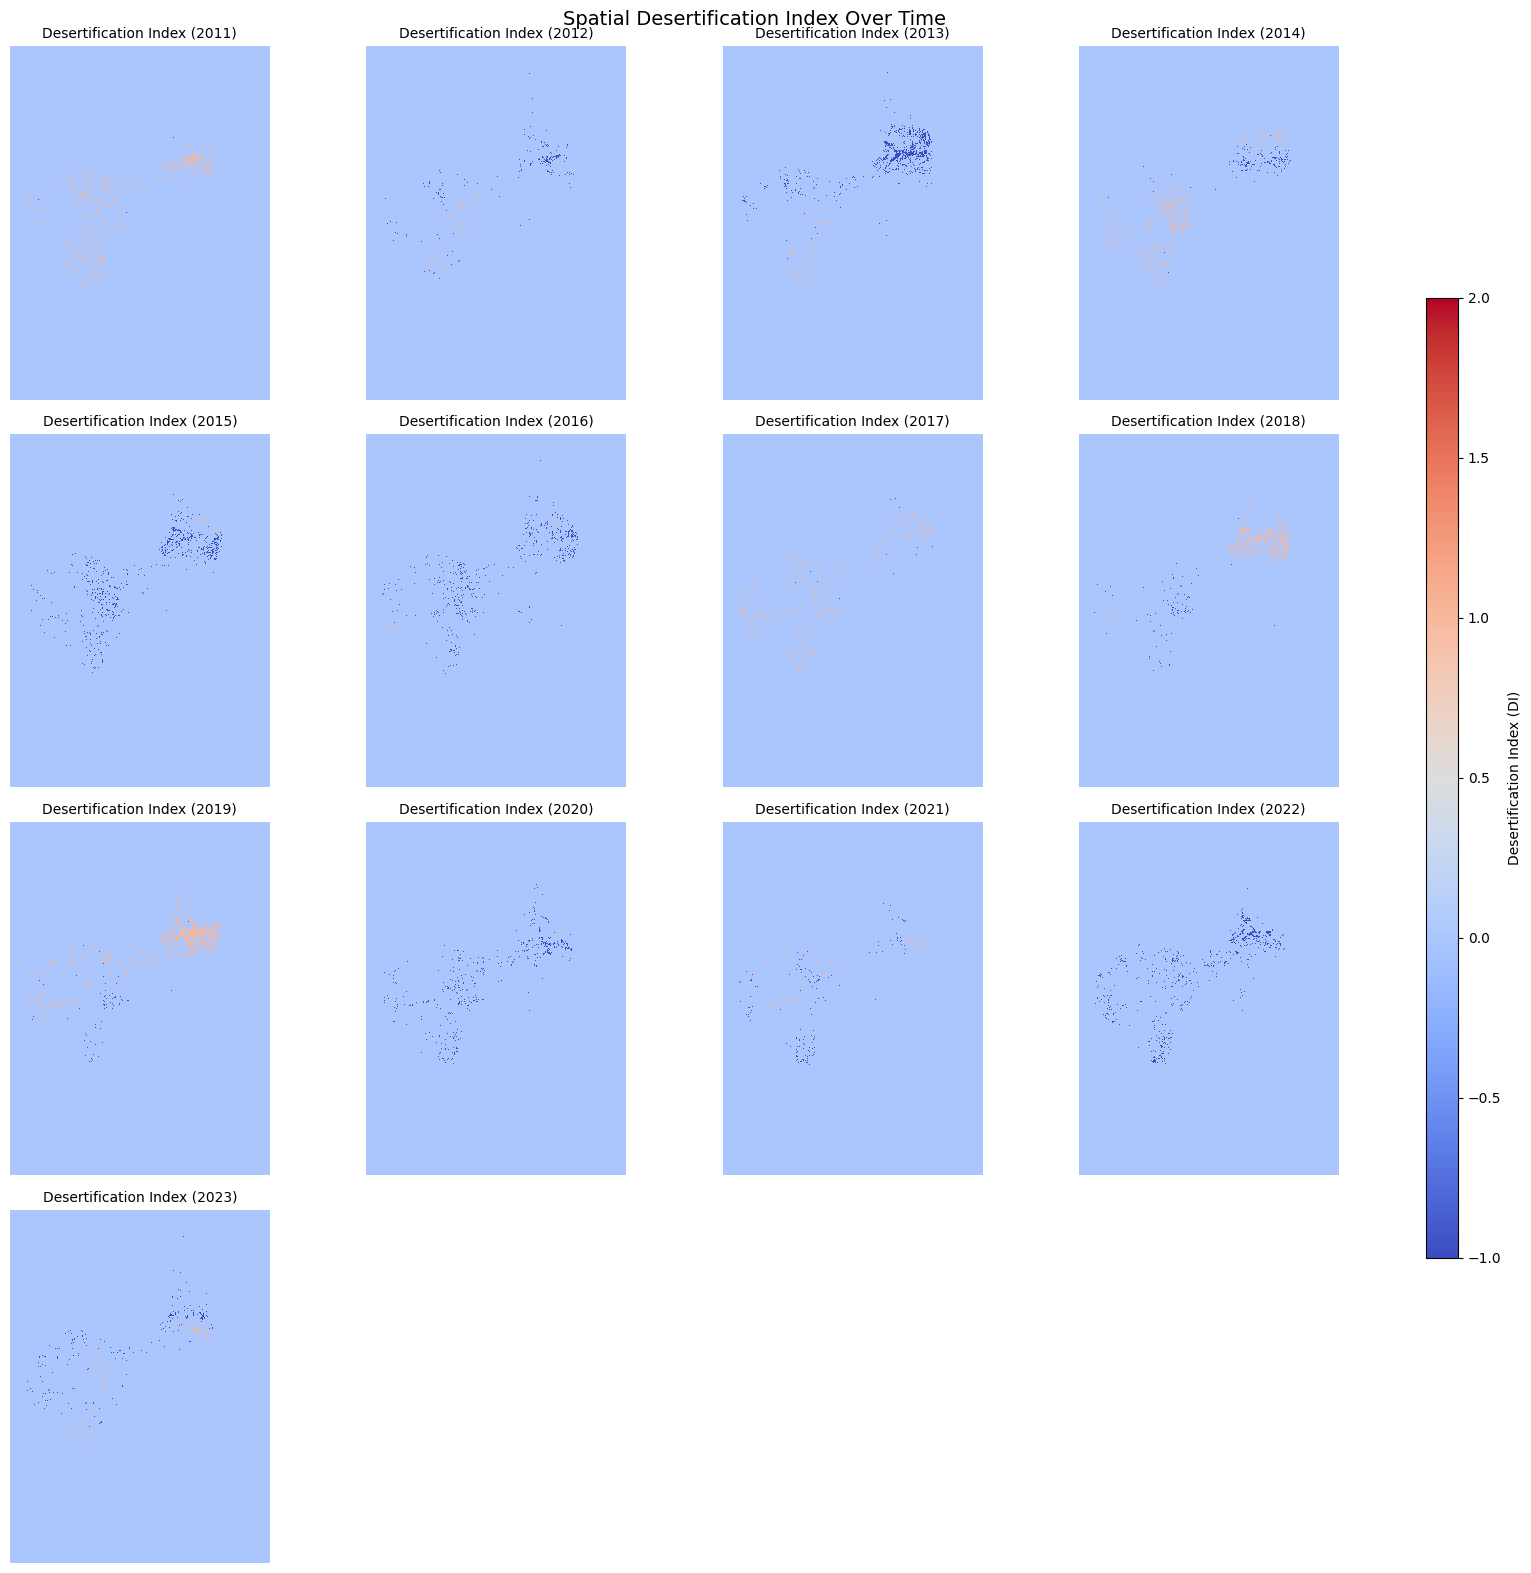

/var/folders/dm/_7xx464s467cm2g79s2z8cvw0000gq/T/ipykernel_28365/3519167152.py:98: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gif_frames.append(imageio.imread(temp_path))


✅ Desertification Index GIF saved as 'desertification_index.gif'


In [52]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import math
import imageio


# ✅ Load Climate Data (Replace with Real Data)
temperature_trend = np.linspace(0.1, 0.5, len(os.listdir(data_folder)))  # Dummy values
rainfall_trend = np.linspace(-5, 5, len(os.listdir(data_folder)))  # Dummy values

# ✅ Initialize Data Storage
land_cover_data = {}
barren_data = {}  # Stores barren land per year
vegetation_data = {}  # Stores vegetation per year (Shrubs + Grasslands)
years = []

# ✅ Load all TIFF files in the folder
for filename in sorted(os.listdir(data_folder)):
    if filename.endswith(".tif"):
        year = int(filename[:4])  # Extract the year
        years.append(year)
        file_path = os.path.join(data_folder, filename)

        with rasterio.open(file_path) as src:
            raw_data = src.read(1)

            # ✅ Remove invalid values (255)
            cleaned_data = np.where(raw_data == 255, np.nan, raw_data)
            land_cover_data[year] = cleaned_data

            # ✅ Extract specific land cover types
            barren_data[year] = np.where(cleaned_data == 16, 1, 0)  # Barren = 1, else 0
            vegetation_data[year] = np.where((cleaned_data == 7) | (cleaned_data == 10), 1, 0)  # Shrubs/Grasslands = 1

# ✅ Compute Yearly Changes in Barren and Vegetation Areas
delta_barren = {}
delta_vegetation = {}

for i in range(1, len(years)):
    year_prev = years[i - 1]
    year_curr = years[i]

    delta_barren[year_curr] = barren_data[year_curr] - barren_data[year_prev]  # Change in barren land
    delta_vegetation[year_curr] = vegetation_data[year_curr] - vegetation_data[year_prev]  # Change in vegetation

# ✅ Compute the Desertification Index (DI) for Each Year
desertification_index = {}

for i in range(1, len(years)):
    year_curr = years[i]

    # Compute DI using pixel-wise calculations
    DI = delta_barren[year_curr]
        # (temperature_trend[i] / (rainfall_trend[i] + 1e-6))

    desertification_index[year_curr] = DI  # Store spatial DI values

# ✅ Visualization: Desertification Index Maps Over Time
num_years = len(desertification_index)
cols = 4
rows = math.ceil(num_years / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten()

for i, year in enumerate(desertification_index.keys()):
    ax = axes[i]
    ax.set_title(f"Desertification Index ({year})", fontsize=10)
    im = ax.imshow(desertification_index[year], cmap="coolwarm", interpolation="nearest", vmin=-1, vmax=2)
    ax.axis("off")  # Hide axis for cleaner visualization

# ✅ Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# ✅ Add colorbar
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
fig.colorbar(im, cax=cbar_ax, label="Desertification Index (DI)")

# ✅ Show final grid layout
plt.suptitle("Spatial Desertification Index Over Time", fontsize=14)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

# ✅ Create an animation of Desertification Index over time
gif_frames = []
for year in desertification_index.keys():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(f"Desertification Index ({year})")
    im = ax.imshow(desertification_index[year], cmap="coolwarm", interpolation="nearest", vmin=-1, vmax=2)
    plt.colorbar(im, ax=ax)

    temp_path = f"desertification_{year}.png"
    plt.savefig(temp_path)
    plt.close()
    gif_frames.append(imageio.imread(temp_path))
    os.remove(temp_path)

imageio.mimsave("desertification_index.gif", gif_frames, duration=1)
print("✅ Desertification Index GIF saved as 'desertification_index.gif'")

/var/folders/dm/_7xx464s467cm2g79s2z8cvw0000gq/T/ipykernel_28365/1114219457.py:43: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  assaba_map["centroid"] = assaba_map.geometry.centroid


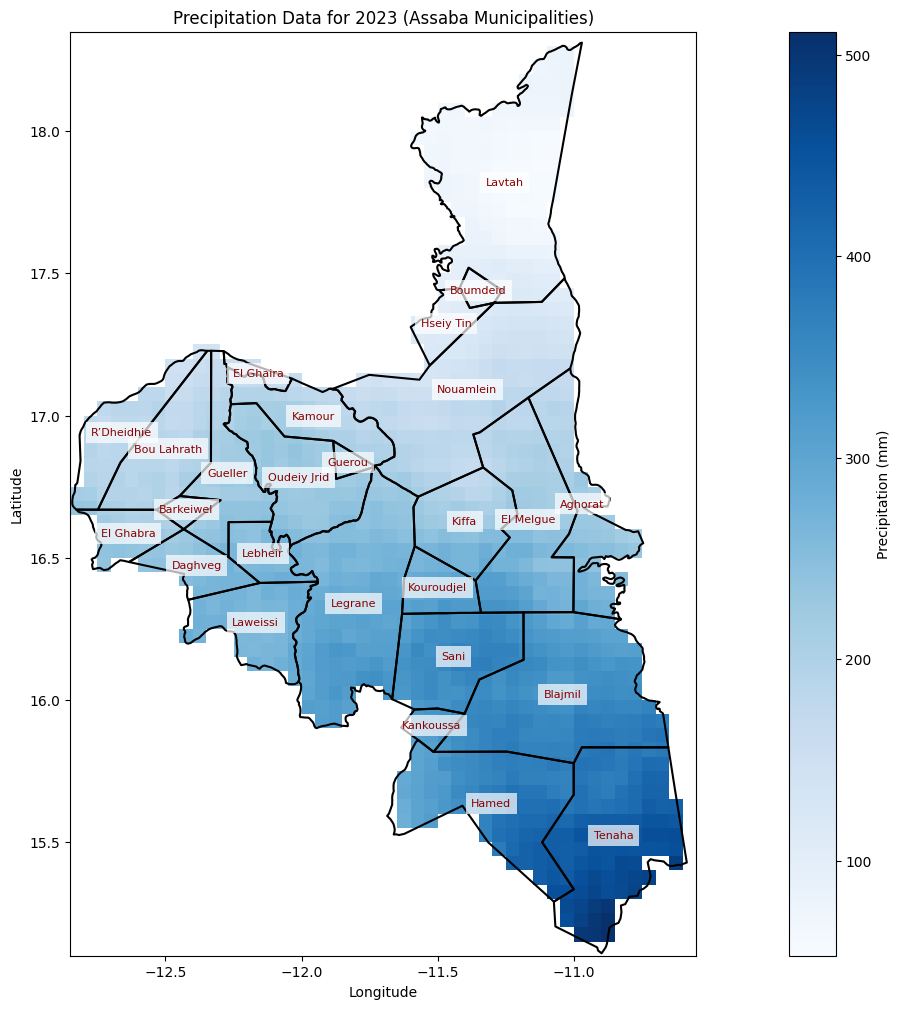

In [53]:
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.mask import mask
from shapely.geometry import mapping

# Define file paths
tif_file = "/Users/niklasviebig/Desktop/STARTxHack/Datasets_Hackathon/Climate_Precipitation_Data/2023R.tif"  # Update with actual file path
shp_file = "/Users/niklasviebig/Desktop/STARTxHack/Datasets_Hackathon/Admin_layers/Assaba_Districts_layer.shp"  # Update with actual file path

# Load the Assaba municipality shapefile
assaba_map = gpd.read_file(shp_file)

# Open the raster dataset and extract metadata
with rasterio.open(tif_file) as dataset:
    raster_crs = dataset.crs  # Get raster projection
    transform = dataset.transform  # Get geotransform

    # Read raster and convert to float for NaN handling
    data = dataset.read(1).astype(float)
    data[data == dataset.nodata] = np.nan  # Mask nodata values

# Ensure Assaba shapefile CRS matches the raster CRS
assaba_map = assaba_map.to_crs(raster_crs)

# Mask and crop raster data to the municipality boundaries
with rasterio.open(tif_file) as dataset:
    clipped_data, clipped_transform = mask(dataset, assaba_map.geometry.map(mapping), crop=True)

# Convert NoData values (masked) to NaN for visualization
clipped_data = clipped_data.astype(float)
clipped_data[clipped_data == dataset.nodata] = np.nan

# Convert row/col to lat/lon using georeferencing for clipped data
height, width = clipped_data.shape[1:]
row_indices, col_indices = np.meshgrid(np.arange(height), np.arange(width), indexing="ij")
lon, lat = rasterio.transform.xy(clipped_transform, row_indices, col_indices)
lon = np.array(lon).reshape(clipped_data.shape[1:])
lat = np.array(lat).reshape(clipped_data.shape[1:])

# Generate centroid for labeling
assaba_map["centroid"] = assaba_map.geometry.centroid
municipality_column = "ADM3_EN"  # Adjust if necessary

# **Plot the clipped precipitation data with municipalities**
fig, ax = plt.subplots(figsize=(24, 12))
im = ax.pcolormesh(lon, lat, clipped_data[0], cmap="Blues", shading="auto")  # Use lat/lon for scaling
plt.colorbar(im, ax=ax, label="Precipitation (mm)")

# Overlay municipality borders
assaba_map.boundary.plot(ax=ax, edgecolor="black", linewidth=1.5)

# Add municipality labels at their centroids
for x, y, label in zip(assaba_map["centroid"].x, assaba_map["centroid"].y, assaba_map[municipality_column]):
    ax.text(
        x, y, label, fontsize=8, ha="center", va="center", 
        color="darkred", bbox=dict(facecolor="white", edgecolor="none", alpha=0.7)
    )

# Final plot enhancements
ax.set_title("Precipitation Data for 2023 (Assaba Municipalities)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the updated map
plt.show()

# Reading in all the code

Assaba Years Available: [2010, 2015, 2020]
Mauritania Years Available: [2000, 2005, 2010, 2015, 2020]


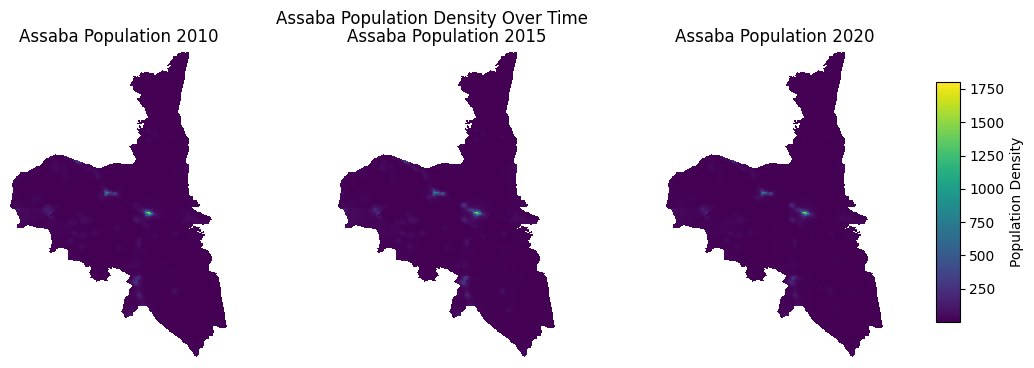

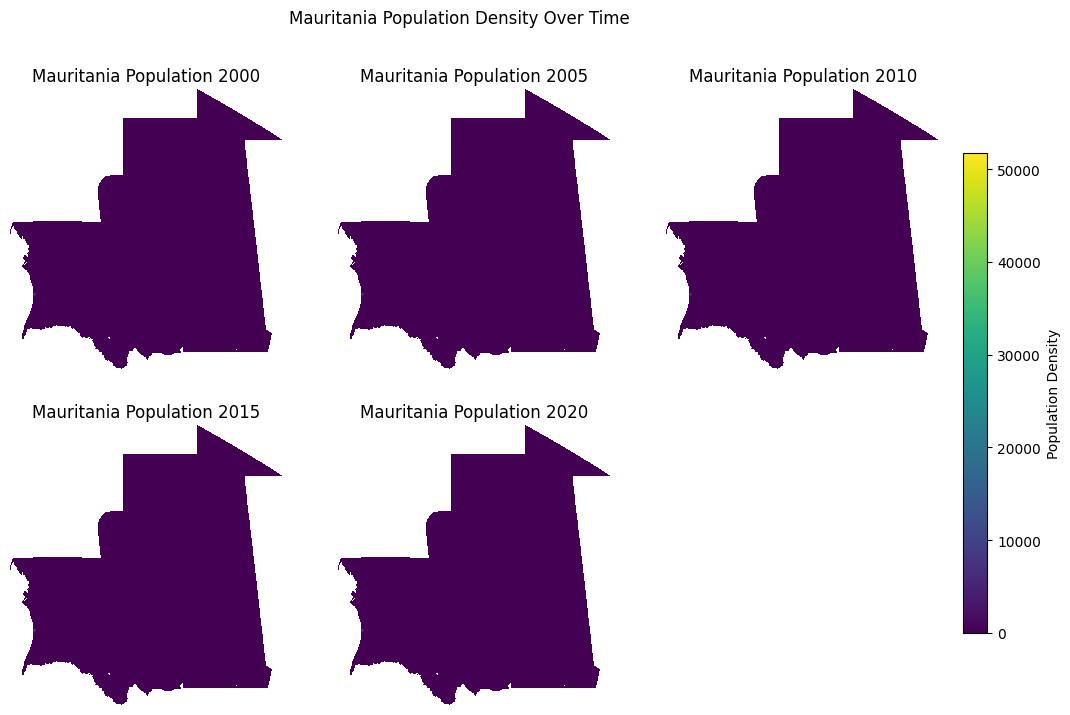

In [54]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# 🔹 Set the data folder (update this path)
data_folder = "/Users/niklasviebig/Desktop/STARTxHack/Datasets_Hackathon/Gridded_Population_Density_Data"  # Change to actual path

# ✅ Dictionaries to store population density data by year
assaba_data = {}
mauritania_data = {}
assaba_years = []
mauritania_years = []

# 🔹 Read all population density TIFF files
for filename in sorted(os.listdir(data_folder)):
    if filename.endswith(".tif") and "aux" not in filename:  # Only .tif files, exclude metadata
        file_path = os.path.join(data_folder, filename)

        # ✅ Separate Mauritania and Assaba based on filename
        if filename.startswith("Assaba_Pop"):
            year = ''.join(filter(str.isdigit, filename))[:4]  # Extract year
            if year.isdigit():
                year = int(year)
                assaba_years.append(year)
                with rasterio.open(file_path) as src:
                    data = src.read(1)  # Read the first band
                    data = np.where(data < 0, np.nan, data)  # Replace invalid values (e.g., -9999) with NaN
                    assaba_data[year] = data

        elif filename.startswith("mrt_pd"):
            year = ''.join(filter(str.isdigit, filename))[:4]  # Extract year
            if year.isdigit():
                year = int(year)
                mauritania_years.append(year)
                with rasterio.open(file_path) as src:
                    data = src.read(1)  # Read the first band
                    data = np.where(data < 0, np.nan, data)  # Replace invalid values
                    mauritania_data[year] = data

# ✅ Sort years
assaba_years.sort()
mauritania_years.sort()

# 🔹 Display metadata
print("Assaba Years Available:", assaba_years)
print("Mauritania Years Available:", mauritania_years)

# 🔹 Plot Assaba Population Density
num_years = len(assaba_years)
cols = 3  # Set columns for grid layout
rows = (num_years // cols) + (num_years % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten()

for i, year in enumerate(assaba_years):
    ax = axes[i]
    ax.set_title(f"Assaba Population {year}")
    im = ax.imshow(assaba_data[year], cmap="viridis", interpolation="nearest")
    ax.axis("off")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
fig.colorbar(im, cax=cbar_ax, label="Population Density")
plt.suptitle("Assaba Population Density Over Time")
plt.show()

# 🔹 Plot Mauritania Population Density
num_years = len(mauritania_years)
cols = 3
rows = (num_years // cols) + (num_years % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten()

for i, year in enumerate(mauritania_years):
    ax = axes[i]
    ax.set_title(f"Mauritania Population {year}")
    im = ax.imshow(mauritania_data[year], cmap="viridis", interpolation="nearest")
    ax.axis("off")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
fig.colorbar(im, cax=cbar_ax, label="Population Density")
plt.suptitle("Mauritania Population Density Over Time")
plt.show()

In [55]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import pandas as pd
from rasterio.mask import mask
from shapely.geometry import mapping

# 🔹 Define paths
precip_folder = "/Users/niklasviebig/Desktop/STARTxHack/Datasets_Hackathon/Climate_Precipitation_Data"
shp_file = "/Users/niklasviebig/Desktop/STARTxHack/Datasets_Hackathon/Admin_layers/Assaba_Districts_layer.shp"

# 🔹 Load Assaba municipality shapefile
assaba_map = gpd.read_file(shp_file)

# ✅ Ensure CRS matches raster data
with rasterio.open(os.path.join(precip_folder, os.listdir(precip_folder)[0])) as sample_dataset:
    raster_crs = sample_dataset.crs
    assaba_map = assaba_map.to_crs(raster_crs)

# 🔹 Initialize a list to store Precipitation data
precip_records = []

# 🔹 Loop through all precipitation TIFF files in the folder
for filename in sorted(os.listdir(precip_folder)):
    if filename.endswith(".tif"):  # Process only .tif files
        year = ''.join(filter(str.isdigit, filename))[:4]  # Extract year
        if year.isdigit():
            year = int(year)
            file_path = os.path.join(precip_folder, filename)

            # ✅ Read and mask raster data
            with rasterio.open(file_path) as dataset:
                transform = dataset.transform  # ✅ Store georeferencing transform
                height, width = dataset.shape  # ✅ Store raster shape
                
                for idx, municipality in assaba_map.iterrows():
                    mask_geom = [mapping(municipality.geometry)]
                    masked_data, _ = mask(dataset, mask_geom, crop=True)
                    masked_data = masked_data.astype(float)
                    masked_data[masked_data == dataset.nodata] = np.nan  # Mask NoData
                    
                    # Flatten pixel values (excluding NaN)
                    pixel_values = masked_data[~np.isnan(masked_data)].flatten().tolist()

                    # Append to records list
                    precip_records.append({
                        "Year": year,
                        "Municipality": municipality["ADM3_EN"],  # Adjust column name if needed
                        "Raw Precipitation Data": pixel_values,  # Store pixel values
                        "Precipitation Transform": transform,  # ✅ Store Transform
                        "Precipitation Height": height,  # ✅ Store raster height
                        "Precipitation Width": width  # ✅ Store raster width
                    })

# 🔹 Convert Precipitation data to a Pandas DataFrame
df_precipitation = pd.DataFrame(precip_records)



In [56]:
df_precipitation

,Year,Municipality,Raw Precipitation Data,Precipitation Transform,Precipitation Height,Precipitation Width
0,2010,El Ghabra,"[443.6405944824219, 428.8487548828125, 412.444...","(0.05000000074505806, 0.0, -12.849997509270906...",65,46
1,2010,Guerou,"[379.74505615234375, 384.70245361328125, 393.0...","(0.05000000074505806, 0.0, -12.849997509270906...",65,46
2,2010,Barkeiwel,"[415.04254150390625, 424.1325988769531, 433.35...","(0.05000000074505806, 0.0, -12.849997509270906...",65,46
3,2010,Legrane,"[377.53729248046875, 402.4753723144531, 392.35...","(0.05000000074505806, 0.0, -12.849997509270906...",65,46
4,2010,Sani,"[412.98211669921875, 424.7081604003906, 425.08...","(0.05000000074505806, 0.0, -12.849997509270906...",65,46
...,...,...,...,...,...,...
359,2023,Nouamlein,"[106.559326171875, 105.68096160888672, 121.698...","(0.05000000074505806, 0.0, -12.849997509270906...",65,46
360,2023,Laweissi,"[271.04315185546875, 269.6746520996094, 261.34...","(0.05000000074505806, 0.0, -12.849997509270906...",65,46
361,2023,Hseiy Tin,"[98.61711120605469, 104.73246765136719, 101.21...","(0.05000000074505806, 0.0, -12.849997509270906...",65,46
362,2023,Kankoussa,"[319.8440246582031, 321.63214111328125, 338.20...","(0.05000000074505806, 0.0, -12.849997509270906...",65,46


In [57]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask

def plot_environmental_data(year):
    """
    Plots a full precipitation map for a given year by reconstructing the raster from municipality data.

    Parameters:
    - year (int): The year to plot.

    Data is extracted from df_precipitation, which contains:
    - Raw Precipitation Data (per municipality)
    - Transform (Georeferencing)
    - Height, Width (Original raster size)
    """

    # ✅ Extract the selected year's data from df_precipitation
    df_year = df_precipitation[df_precipitation["Year"] == year]

    if df_year.empty:
        raise ValueError(f"No precipitation data found for {year}")

    # ✅ Get raster shape and transform
    height = df_year["Height"].values[0]
    width = df_year["Width"].values[0]
    transform = df_year["Transform"].values[0]

    # ✅ Initialize an empty array for the full raster
    full_raster = np.full((height, width), np.nan)  # Fill with NaNs initially

    # ✅ Load the shapefile for municipality boundaries
    assaba_map = gpd.read_file(shp_file)

    # ✅ Loop through each municipality and insert values into the raster
    for _, row in df_year.iterrows():
        pixel_values = np.array(row["Raw Precipitation Data"])
        if len(pixel_values) == 0:
            continue  # Skip if no valid pixels

        # Mask for the municipality
        mask_geom = [assaba_map[assaba_map["ADM3_EN"] == row["Municipality"]].geometry.iloc[0]]

        # Create a mask where this municipality's pixels should be
        mask = geometry_mask(mask_geom, transform=transform, invert=True, out_shape=(height, width))

        # Assign values to the corresponding pixels in the full raster
        masked_indices = np.where(mask)
        pixel_count = min(len(pixel_values), len(masked_indices[0]))

        full_raster[masked_indices[0][:pixel_count], masked_indices[1][:pixel_count]] = pixel_values[:pixel_count]

    # ✅ Convert row/col to lat/lon using georeferencing
    row_indices, col_indices = np.meshgrid(np.arange(height), np.arange(width), indexing="ij")
    lon, lat = rasterio.transform.xy(transform, row_indices, col_indices)
    lon = np.array(lon).reshape(full_raster.shape)
    lat = np.array(lat).reshape(full_raster.shape)

    # **Plot the full precipitation map**
    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.pcolormesh(lon, lat, full_raster, cmap="Blues", shading="auto")  # Use lat/lon for scaling
    plt.colorbar(im, ax=ax, label="Precipitation (mm)")

    # Overlay municipality borders
    assaba_map.boundary.plot(ax=ax, edgecolor="black", linewidth=1.5)

    # Add municipality labels at their centroids
    assaba_map["centroid"] = assaba_map.geometry.centroid
    municipality_column = "ADM3_EN"  # Adjust if necessary

    for x, y, label in zip(assaba_map["centroid"].x, assaba_map["centroid"].y, assaba_map[municipality_column]):
        ax.text(
            x, y, label, fontsize=8, ha="center", va="center", 
            color="darkred", bbox=dict(facecolor="white", edgecolor="none", alpha=0.7)
        )

    # Final plot enhancements
    ax.set_title(f"Precipitation Data for {year} (Assaba Municipalities)")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # Show the map
    plt.show()

🔄 Transforming Assaba CRS from EPSG:4326 to PROJCS["unnamed",GEOGCS["GCS_Unknown_datum_based_upon_the_custom_spheroid",DATUM["D_Not_specified_based_on_custom_spheroid",SPHEROID["Custom_spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
📌 Sample GPP Data:
    Year                                       Raw GPP Data  \
0  2010  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1  2011  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2  2012  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
3  2013  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4  2014  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                       GPP Transform  GPP Height  GPP Width  
0  (463.31271652749996, 0.0, -1

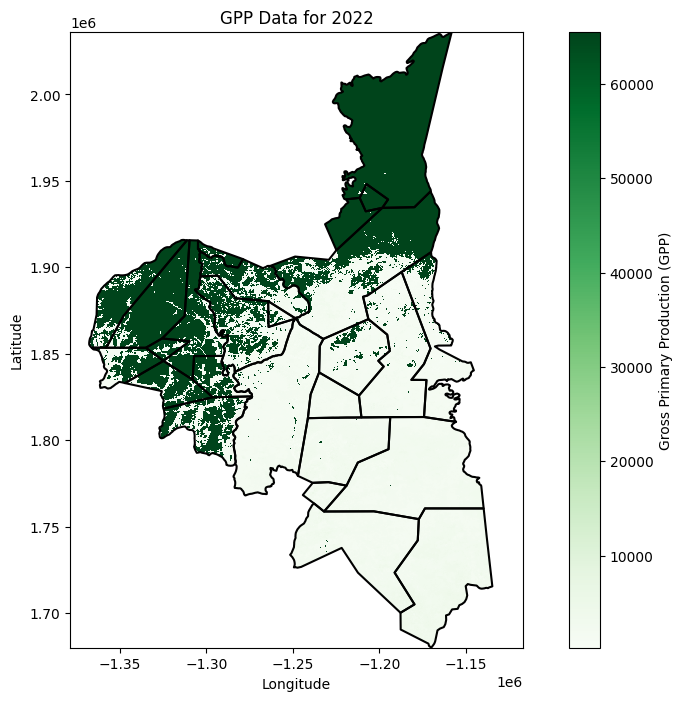

In [58]:
import os
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# 🔹 Define paths for GPP data
gpp_folder = "/Users/niklasviebig/Desktop/STARTxHack/Datasets_Hackathon/MODIS_Gross_Primary_Production_GPP"

# 🔹 Load the Assaba municipality shapefile
assaba_map = gpd.read_file(shp_file)

# ✅ Ensure CRS matches raster before processing
with rasterio.open(os.path.join(gpp_folder, os.listdir(gpp_folder)[0])) as sample_dataset:
    raster_crs = sample_dataset.crs
    if assaba_map.crs != raster_crs:
        print(f"🔄 Transforming Assaba CRS from {assaba_map.crs} to {raster_crs}")
        assaba_map = assaba_map.to_crs(raster_crs)

# 🔹 Initialize storage for GPP data
gpp_records = []

# ✅ Extract FULL GPP Raster Instead of Individual Municipalities
for filename in sorted(os.listdir(gpp_folder)):
    if filename.endswith(".tif"):  # Process only .tif files
        year = ''.join(filter(str.isdigit, filename))[:4]  # Extract year
        if year.isdigit():
            year = int(year)
            file_path = os.path.join(gpp_folder, filename)

            # ✅ Read full GPP raster
            with rasterio.open(file_path) as dataset:
                transform = dataset.transform
                height, width = dataset.shape
                
                # ✅ Read the full raster
                gpp_data = dataset.read(1).astype(float)
                gpp_data[gpp_data == dataset.nodata] = np.nan  # Mask NoData
                
                # ✅ Store the entire raster for this year
                gpp_records.append({
                    "Year": year,
                    "Raw GPP Data": gpp_data.flatten().tolist(),  # Store full raster as 1D array
                    "GPP Transform": transform,
                    "GPP Height": height,
                    "GPP Width": width
                })

# 🔹 Convert GPP data to a Pandas DataFrame
df_gpp = pd.DataFrame(gpp_records)

# ✅ Check if data is correct
print("📌 Sample GPP Data:\n", df_gpp.head())

# 🔹 Function to Plot Full GPP Raster (No Municipalities)
def plot_full_gpp(year):
    """Plots the full GPP raster for the selected year."""
    df_gpp_year = df_gpp[df_gpp["Year"] == year]
    
    if df_gpp_year.empty:
        print(f"❌ No GPP data found for {year}")
        return

    # ✅ Extract raster data
    pixel_values = np.array(df_gpp_year["Raw GPP Data"].values[0]).reshape(
        df_gpp_year["GPP Height"].values[0], df_gpp_year["GPP Width"].values[0]
    )
    transform = df_gpp_year["GPP Transform"].values[0]

    # ✅ Convert row/col to lat/lon using georeferencing
    row_indices, col_indices = np.meshgrid(np.arange(pixel_values.shape[0]), np.arange(pixel_values.shape[1]), indexing="ij")
    lon, lat = rasterio.transform.xy(transform, row_indices, col_indices)
    lon = np.array(lon).reshape(pixel_values.shape)
    lat = np.array(lat).reshape(pixel_values.shape)

    # **Plot the full GPP Raster**
    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.pcolormesh(lon, lat, pixel_values, cmap="Greens", shading="auto")
    plt.colorbar(im, ax=ax, label="Gross Primary Production (GPP)")

    # ✅ Overlay municipality borders
    assaba_map.boundary.plot(ax=ax, edgecolor="black", linewidth=1.5)

    # ✅ Final plot adjustments
    ax.set_title(f"GPP Data for {year}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # ✅ Show the map
    plt.show()

# **Run the GPP Plot for a Specific Year**
plot_full_gpp(2022)

In [59]:
import os
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
from rasterio.mask import mask
from shapely.geometry import mapping

# 🔹 Define paths for GPP data
gpp_folder = "/Users/niklasviebig/Desktop/STARTxHack/Datasets_Hackathon/MODIS_Gross_Primary_Production_GPP"

# 🔹 Load the Assaba municipality shapefile
assaba_map = gpd.read_file(shp_file)

# ✅ Ensure CRS matches raster before processing
with rasterio.open(os.path.join(gpp_folder, os.listdir(gpp_folder)[0])) as sample_dataset:
    raster_crs = sample_dataset.crs
    if assaba_map.crs != raster_crs:
        print(f"🔄 Transforming Assaba CRS from {assaba_map.crs} to {raster_crs}")
        assaba_map = assaba_map.to_crs(raster_crs)

# 🔹 Initialize storage for GPP data
gpp_records = []

# ✅ Extract GPP Data PER MUNICIPALITY
for filename in sorted(os.listdir(gpp_folder)):
    if filename.endswith(".tif"):  # Process only .tif files
        year = ''.join(filter(str.isdigit, filename))[:4]  # Extract year
        if year.isdigit():
            year = int(year)
            file_path = os.path.join(gpp_folder, filename)

            # ✅ Read full GPP raster
            with rasterio.open(file_path) as dataset:
                transform = dataset.transform
                height, width = dataset.shape

                # ✅ Loop through municipalities and extract GPP data
                for idx, municipality in assaba_map.iterrows():
                    mask_geom = [mapping(municipality.geometry)]

                    try:
                        masked_data, _ = mask(dataset, mask_geom, crop=True)
                    except ValueError:
                        print(f"⚠️ Warning: {municipality['ADM3_EN']} does not overlap raster. Skipping.")
                        continue  # Skip non-overlapping municipalities

                    masked_data = masked_data.astype(float)
                    masked_data[masked_data == dataset.nodata] = np.nan  # Mask NoData
                    
                    # ✅ Store valid pixel values
                    pixel_values = masked_data[~np.isnan(masked_data)].flatten().tolist()

                    # ✅ Store data per municipality
                    gpp_records.append({
                        "Year": year,
                        "Municipality": municipality["ADM3_EN"],  # Adjust column name if needed
                        "Raw GPP Data": pixel_values,  # Store pixel values per municipality
                    })

# 🔹 Convert GPP data to a Pandas DataFrame
df_gpp_municipality = pd.DataFrame(gpp_records)

# ✅ Merge with Precipitation DataFrame
df_combined = pd.merge(df_precipitation, df_gpp_municipality, on=["Year", "Municipality"], how="inner")


🔄 Transforming Assaba CRS from EPSG:4326 to PROJCS["unnamed",GEOGCS["GCS_Unknown_datum_based_upon_the_custom_spheroid",DATUM["D_Not_specified_based_on_custom_spheroid",SPHEROID["Custom_spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [60]:
df_gpp_municipality

,Year,Municipality,Raw GPP Data
0,2010,El Ghabra,"[903.0, 927.0, 892.0, 65533.0, 65533.0, 1032.0..."
1,2010,Guerou,"[843.0, 872.0, 596.0, 870.0, 707.0, 642.0, 670..."
2,2010,Barkeiwel,"[65533.0, 65533.0, 65533.0, 65533.0, 65533.0, ..."
3,2010,Legrane,"[1008.0, 779.0, 794.0, 620.0, 578.0, 438.0, 54..."
4,2010,Sani,"[651.0, 759.0, 976.0, 1077.0, 1087.0, 1093.0, ..."
...,...,...,...
359,2023,Nouamlein,"[65533.0, 65533.0, 65533.0, 65533.0, 65533.0, ..."
360,2023,Laweissi,"[1531.0, 1304.0, 1697.0, 1679.0, 1211.0, 1336...."
361,2023,Hseiy Tin,"[65533.0, 65533.0, 65533.0, 65533.0, 65533.0, ..."
362,2023,Kankoussa,"[1186.0, 1238.0, 1323.0, 1366.0, 1318.0, 1219...."


In [61]:
df_precipitation

,Year,Municipality,Raw Precipitation Data,Precipitation Transform,Precipitation Height,Precipitation Width
0,2010,El Ghabra,"[443.6405944824219, 428.8487548828125, 412.444...","(0.05000000074505806, 0.0, -12.849997509270906...",65,46
1,2010,Guerou,"[379.74505615234375, 384.70245361328125, 393.0...","(0.05000000074505806, 0.0, -12.849997509270906...",65,46
2,2010,Barkeiwel,"[415.04254150390625, 424.1325988769531, 433.35...","(0.05000000074505806, 0.0, -12.849997509270906...",65,46
3,2010,Legrane,"[377.53729248046875, 402.4753723144531, 392.35...","(0.05000000074505806, 0.0, -12.849997509270906...",65,46
4,2010,Sani,"[412.98211669921875, 424.7081604003906, 425.08...","(0.05000000074505806, 0.0, -12.849997509270906...",65,46
...,...,...,...,...,...,...
359,2023,Nouamlein,"[106.559326171875, 105.68096160888672, 121.698...","(0.05000000074505806, 0.0, -12.849997509270906...",65,46
360,2023,Laweissi,"[271.04315185546875, 269.6746520996094, 261.34...","(0.05000000074505806, 0.0, -12.849997509270906...",65,46
361,2023,Hseiy Tin,"[98.61711120605469, 104.73246765136719, 101.21...","(0.05000000074505806, 0.0, -12.849997509270906...",65,46
362,2023,Kankoussa,"[319.8440246582031, 321.63214111328125, 338.20...","(0.05000000074505806, 0.0, -12.849997509270906...",65,46


In [69]:
import os
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
from rasterio.mask import mask
from shapely.geometry import mapping

# 🔹 Define paths for GPP data
gpp_folder = "/Users/niklasviebig/Desktop/STARTxHack/Datasets_Hackathon/MODIS_Gross_Primary_Production_GPP"
shp_file = "/Users/niklasviebig/Desktop/STARTxHack/Datasets_Hackathon/Admin_layers/Assaba_Districts_layer.shp"

# 🔹 Load the Assaba municipality shapefile
assaba_map = gpd.read_file(shp_file)

# ✅ Ensure CRS matches raster before processing
with rasterio.open(os.path.join(gpp_folder, sorted([f for f in os.listdir(gpp_folder) if f.endswith(".tif")])[0])) as sample_dataset:
    raster_crs = sample_dataset.crs
    if assaba_map.crs != raster_crs:
        print(f"🔄 Transforming Assaba CRS from {assaba_map.crs} to {raster_crs}")
        assaba_map = assaba_map.to_crs(raster_crs)

# 🔹 Initialize storage for GPP data
gpp_records = []
transform_records = {}  # ✅ Dictionary to store Transform per year

# ✅ Extract GPP Data PER MUNICIPALITY
for filename in sorted(os.listdir(gpp_folder)):
    if filename.endswith(".tif"):  # Process only .tif files
        year = ''.join(filter(str.isdigit, filename))[:4]  # Extract year
        if year.isdigit():
            year = int(year)
            file_path = os.path.join(gpp_folder, filename)

            print(f"📂 Processing: {filename} (Year: {year})")  # Debugging output

            # ✅ Read full GPP raster
            with rasterio.open(file_path) as dataset:
                transform = dataset.transform
                height, width = dataset.shape

                # ✅ Store transform data ONCE per year
                transform_records[year] = {
                    "GPP Transform": transform,
                    "GPP Height": height,
                    "GPP Width": width
                }

                # ✅ Loop through municipalities and extract GPP data
                for idx, municipality in assaba_map.iterrows():
                    mask_geom = [mapping(municipality.geometry)]

                    try:
                        masked_data, _ = mask(dataset, mask_geom, crop=True)
                    except ValueError:
                        print(f"⚠️ Warning: {municipality['ADM3_EN']} does not overlap raster. Skipping.")
                        continue  # Skip non-overlapping municipalities

                    masked_data = masked_data.astype(float)
                    masked_data[masked_data == dataset.nodata] = np.nan  # Mask NoData
                    
                    # ✅ Apply Correct GPP Scaling
                    masked_data[masked_data > 4000] = np.nan  # Remove unrealistic values
                    masked_data *= 0.0001  # Convert from MODIS units

                    # ✅ Store valid pixel values
                    pixel_values = masked_data[~np.isnan(masked_data)].flatten().tolist()

                    # ✅ Store data per municipality
                    gpp_records.append({
                        "Year": year,
                        "Municipality": municipality["ADM3_EN"],  # Adjust column name if needed
                        "Raw GPP Data": pixel_values,  # Store pixel values per municipality
                    })

# 🔹 Convert GPP data to a Pandas DataFrame
df_gpp_municipality = pd.DataFrame(gpp_records)

# 🔹 Convert Transform Data to DataFrame & Merge
df_gpp_transform = pd.DataFrame(transform_records).T.reset_index().rename(columns={"index": "Year"})

# 🔹 Merge Transform Data into `df_gpp_municipality`
df_gpp_municipality = pd.merge(df_gpp_municipality, df_gpp_transform, on="Year", how="left")

# ✅ Print Data Samples
print("📌 Sample of Extracted GPP per Municipality:\n", df_gpp_municipality.head())

# ✅ Debugging: Check if data is missing or incorrect
print(f"📊 Total records extracted: {len(df_gpp_municipality)}")
print(f"🔢 Unique Years: {df_gpp_municipality['Year'].unique()}")
print(f"🏙️ Unique Municipalities: {df_gpp_municipality['Municipality'].unique()}")


🔄 Transforming Assaba CRS from EPSG:4326 to PROJCS["unnamed",GEOGCS["GCS_Unknown_datum_based_upon_the_custom_spheroid",DATUM["D_Not_specified_based_on_custom_spheroid",SPHEROID["Custom_spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
📂 Processing: 2010_GP.tif (Year: 2010)
📂 Processing: 2011_GP.tif (Year: 2011)
📂 Processing: 2012_GP.tif (Year: 2012)
📂 Processing: 2013_GP.tif (Year: 2013)
📂 Processing: 2014_GP.tif (Year: 2014)
📂 Processing: 2015_GP.tif (Year: 2015)
📂 Processing: 2016_GP.tif (Year: 2016)
📂 Processing: 2017_GP.tif (Year: 2017)
📂 Processing: 2018_GP.tif (Year: 2018)
📂 Processing: 2019_GP.tif (Year: 2019)
📂 Processing: 2020_GP.tif (Year: 2020)
📂 Processing: 2021_GP.tif (Year: 2021)
📂 Processing: 2022_GP.tif (Year: 2

In [70]:
df_total = pd.merge(df_precipitation, df_gpp_municipality, on=["Year", "Municipality"], how="inner")

In [71]:
df_total


,Year,Municipality,Raw Precipitation Data,Precipitation Transform,Precipitation Height,Precipitation Width,Raw GPP Data,GPP Transform,GPP Height,GPP Width
0,2010,El Ghabra,"[443.6405944824219, 428.8487548828125, 412.444...","(0.05000000074505806, 0.0, -12.849997509270906...",65,46,"[0.0903, 0.0927, 0.0892, 0.1032, 0.0989, 0.089...","(463.31271652749996, 0.0, -1378818.64438684, 0...",769,565
1,2010,Guerou,"[379.74505615234375, 384.70245361328125, 393.0...","(0.05000000074505806, 0.0, -12.849997509270906...",65,46,"[0.0843, 0.0872, 0.0596, 0.08700000000000001, ...","(463.31271652749996, 0.0, -1378818.64438684, 0...",769,565
2,2010,Barkeiwel,"[415.04254150390625, 424.1325988769531, 433.35...","(0.05000000074505806, 0.0, -12.849997509270906...",65,46,"[0.0742, 0.0913, 0.0995, 0.10020000000000001, ...","(463.31271652749996, 0.0, -1378818.64438684, 0...",769,565
3,2010,Legrane,"[377.53729248046875, 402.4753723144531, 392.35...","(0.05000000074505806, 0.0, -12.849997509270906...",65,46,"[0.1008, 0.0779, 0.0794, 0.062, 0.057800000000...","(463.31271652749996, 0.0, -1378818.64438684, 0...",769,565
4,2010,Sani,"[412.98211669921875, 424.7081604003906, 425.08...","(0.05000000074505806, 0.0, -12.849997509270906...",65,46,"[0.0651, 0.07590000000000001, 0.0976, 0.1077, ...","(463.31271652749996, 0.0, -1378818.64438684, 0...",769,565
...,...,...,...,...,...,...,...,...,...,...
359,2023,Nouamlein,"[106.559326171875, 105.68096160888672, 121.698...","(0.05000000074505806, 0.0, -12.849997509270906...",65,46,"[0.07300000000000001, 0.0466, 0.0317, 0.038700...","(463.31271652749996, 0.0, -1378818.64438684, 0...",769,565
360,2023,Laweissi,"[271.04315185546875, 269.6746520996094, 261.34...","(0.05000000074505806, 0.0, -12.849997509270906...",65,46,"[0.1531, 0.13040000000000002, 0.16970000000000...","(463.31271652749996, 0.0, -1378818.64438684, 0...",769,565
361,2023,Hseiy Tin,"[98.61711120605469, 104.73246765136719, 101.21...","(0.05000000074505806, 0.0, -12.849997509270906...",65,46,"[0.06280000000000001, 0.0738, 0.0625]","(463.31271652749996, 0.0, -1378818.64438684, 0...",769,565
362,2023,Kankoussa,"[319.8440246582031, 321.63214111328125, 338.20...","(0.05000000074505806, 0.0, -12.849997509270906...",65,46,"[0.11860000000000001, 0.12380000000000001, 0.1...","(463.31271652749996, 0.0, -1378818.64438684, 0...",769,565


In [73]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask

def plot_environmental_data(year, keyword):
    """
    Plots a full environmental map (GPP or Precipitation) for a given year.

    Parameters:
    - year (int): The year to plot.
    - keyword (str): "GPP" or "Precipitation" to choose which dataset to visualize.

    Data is extracted from df_total, which contains:
    - Raw GPP Data
    - Raw Precipitation Data
    - Transform (Georeferencing)
    - Height, Width (Original raster size)
    """

    # ✅ Extract the selected year's data
    df_year = df_total[df_total["Year"] == year]

    if df_year.empty:
        raise ValueError(f"No data found for {year}")

    # ✅ Determine which data column to use
    if keyword.lower() == "gpp":
        data_column = "Raw GPP Data"
        cmap = "Greens"
        label = "Gross Primary Production (GPP)"
        transform = df_year["GPP Transform"].values[0]
        height = df_year["GPP Height"].values[0]
        width = df_year["GPP Width"].values[0]
        
    elif keyword.lower() == "precipitation":
        data_column = "Raw Precipitation Data"
        cmap = "Blues"
        label = "Precipitation (mm)"
        transform = df_year["Precipitation Transform"].values[0]
        height = df_year["Precipitation Height"].values[0]
        width = df_year["Precipitation Width"].values[0]
    else:
        raise ValueError("Keyword must be 'GPP' or 'Precipitation'")

    # ✅ Ensure transform is correct
    print(f"📌 Using transform: {transform}")

    # ✅ Initialize an empty array for the full raster
    full_raster = np.full((height, width), np.nan)  # Fill with NaNs initially

    # ✅ Load the shapefile for municipality boundaries
    assaba_map = gpd.read_file(shp_file)

    # ✅ Ensure CRS matches
    raster_crs = rasterio.crs.CRS.from_epsg(4326)  # Adjust based on the dataset
    if assaba_map.crs != raster_crs:
        print(f"🔄 Transforming Assaba CRS from {assaba_map.crs} to {raster_crs}")
        assaba_map = assaba_map.to_crs(raster_crs)

    # ✅ Loop through each municipality and insert values into the raster
    for _, row in df_year.iterrows():
        pixel_values = np.array(row[data_column])
        if len(pixel_values) == 0:
            continue  # Skip if no valid pixels

        # Mask for the municipality
        mask_geom = [assaba_map[assaba_map["ADM3_EN"] == row["Municipality"]].geometry.iloc[0]]

        # Create a mask where this municipality's pixels should be
        mask = geometry_mask(mask_geom, transform=transform, invert=True, out_shape=(height, width))

        # Assign values to the corresponding pixels in the full raster
        masked_indices = np.where(mask)
        pixel_count = min(len(pixel_values), len(masked_indices[0]))

        full_raster[masked_indices[0][:pixel_count], masked_indices[1][:pixel_count]] = pixel_values[:pixel_count]

    # ✅ Convert row/col to lat/lon using georeferencing
    row_indices, col_indices = np.meshgrid(np.arange(height), np.arange(width), indexing="ij")
    lon, lat = rasterio.transform.xy(transform, row_indices, col_indices)
    
    lon = np.array(lon).reshape(full_raster.shape)
    lat = np.array(lat).reshape(full_raster.shape)

    # ✅ Debug: Check min/max lat/lon
    print(f"Min/Max Lon: {lon.min()} / {lon.max()}")
    print(f"Min/Max Lat: {lat.min()} / {lat.max()}")

    # **Plot the full environmental map**
    fig, ax = plt.subplots(figsize=(15, 10))  # 🔹 Increased figure size
    im = ax.pcolormesh(lon, lat, full_raster, cmap=cmap, shading="auto")  # Use lat/lon for scaling
    plt.colorbar(im, ax=ax, label=label)

    # Overlay municipality borders
    assaba_map.boundary.plot(ax=ax, edgecolor="black", linewidth=1.5)

    # Add municipality labels at their centroids
    assaba_map["centroid"] = assaba_map.geometry.centroid
    municipality_column = "ADM3_EN"  # Adjust if necessary

    for x, y, label in zip(assaba_map["centroid"].x, assaba_map["centroid"].y, assaba_map[municipality_column]):
        ax.text(
            x, y, label, fontsize=10, ha="center", va="center", 
            color="darkred", bbox=dict(facecolor="white", edgecolor="none", alpha=0.7)
        )

    # Final plot enhancements
    ax.set_title(f"{year} {keyword} Assaba Municipalities", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)

    # Show the map
    plt.show()

📌 Using transform: | 463.31, 0.00,-1378818.64|
| 0.00,-463.31, 2036259.39|
| 0.00, 0.00, 1.00|
Min/Max Lon: -1378586.9880285764 / -1117278.6159070663
Min/Max Lat: 1680203.5664879784 / 2036027.7327810985


/var/folders/dm/_7xx464s467cm2g79s2z8cvw0000gq/T/ipykernel_28365/3179206840.py:100: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  assaba_map["centroid"] = assaba_map.geometry.centroid


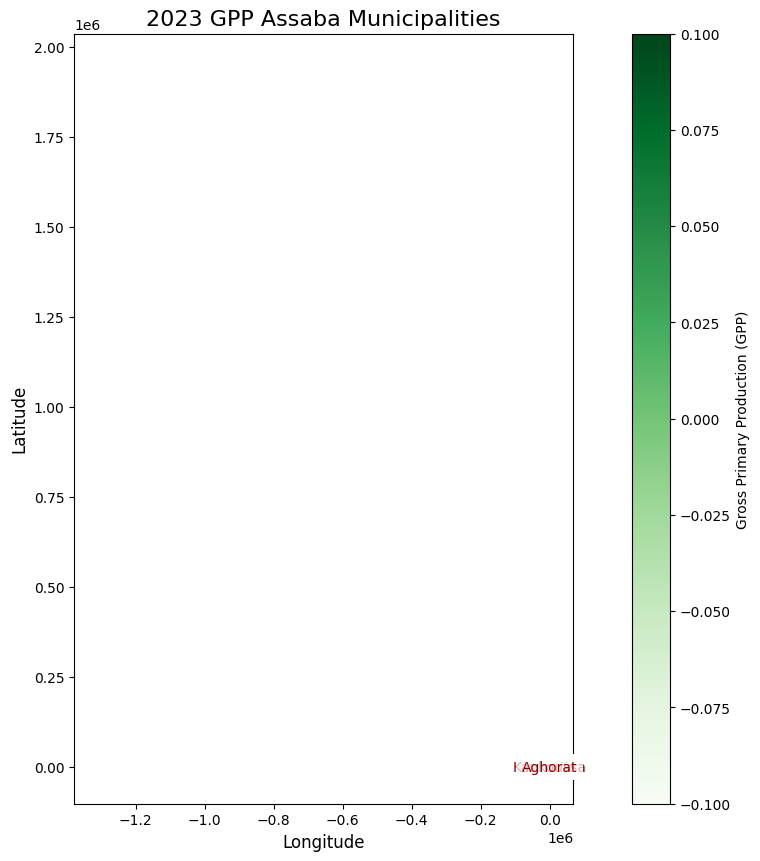

In [76]:
plot_environmental_data(2023, "GPP")